# Продвинутые возможности фреймворка PyTorch.

### Март 2025

На сегодняшнем семинаре мы рассмотрим следующие темы:
1. Создание собственных датасетов и особенности работы с данными
2. Кастомизация моделей и создание собственных операторов
3. Распределённое обучение моделей
4. Обучение моделей в режиме пониженной точности вычислений

## Создание собственных датасетов и особенности работы с данными

Этот раздел является вольным переводом примеров из документации PyTorch. Оригинал: https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html

Существенная часть усилий по созданию моделей машинного обучения связана с подготовкой данных.
PyTorch имеет множество средств для быстрой и удобной загрузки данных, в том числе:
1. Создание собственного датасета
2. Создание преобразований данных, которые можно объединять
3. Объединение датасетов и преобразований данных и создание даталоадеров

Для дальнейшей работы нам понадобятся пакеты matplotlib, scikit-image и pandas.

Импортируем необходимые пакеты:

In [1]:
from __future__ import print_function, division

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

torch.manual_seed(100)

In [2]:
print(torch.__version__)

2.7.0+cu128


В качестве примера мы будем использовать датасет с разметкой ключевых точек лиц, доступный по этой ссылке: https://download.pytorch.org/tutorial/faces.zip

С каждым лицом связано 68 ключевых точек. Разметка находится в файле face_landmarks.csv и выглядит следующим образом:

```
image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x, ... ,part_67_x,part_67_y
0805personali01.jpg,27,83,27,98, ... 84,134
1084239450_e76e00b7e7.jpg,70,236,71,257, ... ,128,312
```

In [3]:
dataset_path = "./faces/"

In [4]:
landmarks_frame = pd.read_csv(os.path.join(dataset_path, "face_landmarks.csv"))

landmarks_frame.head()

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,...,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,...,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,...,293,507,331,511,294,516,279,518,265,516


In [5]:
n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks)
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


Напишем вспомогательную функцию для отображения данных.

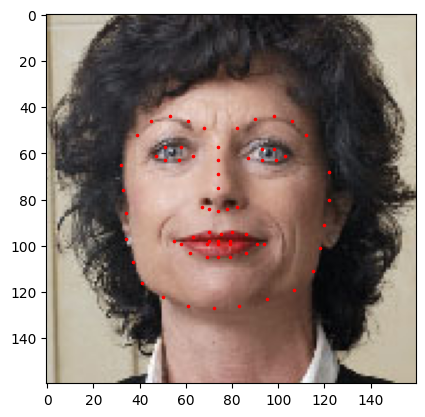

In [6]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join(dataset_path, img_name)),
               landmarks)
plt.show()

Создадим класс датасета. Для этого необходимо унаследовать класс абстрактного датасета torch.utils.data.Dataset и определить в нём следующие методы:

\_\_len\_\_ - так, чтобы вызов len(dataset) возвращал размер датасета (т.е. количество объектов).

\_\_getitem\_\_ - для поддержки получения объекта по индексу: dataset[i]

В конструкторе \_\_init\_\_ мы прочитаем csv-файл с разметкой, но чтение изображений будем делать в методе \_\_getitem\_\_. Такой подход лучше масштабируется на большие датасеты, которые невозможно хранить в оперативной памяти целиком.

In [7]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Путь к CSV-файлу с разметкой.
            root_dir (string): Корневая директория и изображениями.
            transform (callable, optional): Необязательные трансформации, применяемые к изображениями.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

Для проверки работы класса создадим объект датасета, проитерируемся по нему и отобразим первые 4 объекта.

0 (324, 215, 3) (68, 2)


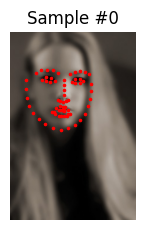

1 (500, 333, 3) (68, 2)


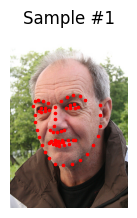

2 (250, 258, 3) (68, 2)


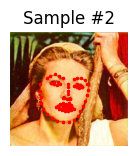

3 (434, 290, 3) (68, 2)


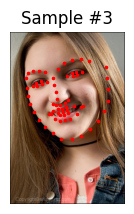

In [8]:
face_dataset = FaceLandmarksDataset(csv_file=os.path.join(dataset_path, 'face_landmarks.csv'),
                                    root_dir=dataset_path)

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

Мы можем видеть, что изображения имеют различный размер.
При разработке моделей компьютерного зрения модель, как правило, работает с изображениями фиксированного размера.
Кроме того, мы произведём аугментацию данных.

Таким образом, нам требуется применить к данным следующие преобразования:
1. Rescale: Для масштабирования изображения
2. RandomCrop: Для выделения случайной прямоугольной области из изображения. Это произведёт аугментацию изображений.
3. ToTensor: Для того, чтобы преобразовать массивы numpy к тензорам PyTorch.

В PyTorch преобразования данных являются вызываемыми объектами, для которых должен быть определён метод \_\_call\_\_ и, при необходимости, \_\_init\_\_. Сделав это, мы сможем делать преобразование следующим образом:

```
tsfm = Transform(params)
transformed_sample = tsfm(sample)
```
Определим классы трансформаций:

In [9]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # При изменении изображения необходимо соответствующим образом изменить координаты ключевых точек
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        # При изменении изображения необходимо соответствующим образом изменить координаты ключевых точек
        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # Необходимо изменить порядок размерностей, так как в skimage (numpy) и PyTorch они отличаются
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

Объединим преобразования с помощью transforms.Compose и применим их к данным:

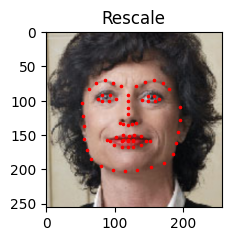

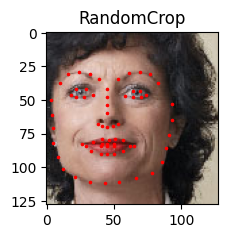

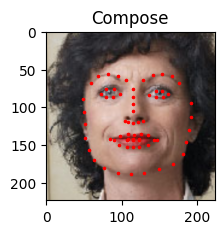

In [10]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

Теперь мы можем передать заданные преобразования в конструктор датасета:

In [11]:
transformed_dataset = FaceLandmarksDataset(csv_file=os.path.join(dataset_path, 'face_landmarks.csv'),
                                           root_dir=dataset_path,
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


Объединим всё вместе с помощью даталоадера, который позволяет: 
1. Получать данные батчами
2. Получать данные в случайном порядке
3. Загружать данные параллельно несколькими процессами

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


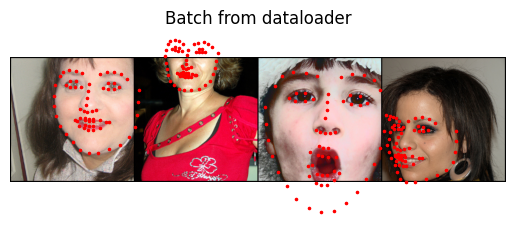

In [12]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


# Вспомогательная функция для отображения батча данных
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # Отобразим четвёртый батч и остановимся
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

## Кастомизация моделей и создание собственных операторов

Существует четыре способа расширения функциональности PyTorch собственными операциями:
1. Имплементация модулей с помощью существующих примитивов torch.nn или ops.
2. Имплементация функция torch.autograd
3. Расширение torch
4. Имплементация модулей на C++ (с помощью Torch C++ API или на CUDA)

Детально мы остановимся только на первом методе.

Возьмём код обучения модели, который мы рассматривали на первом семинаре.

In [13]:
import torch
import numpy as np
torch.manual_seed(100)
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

torch.manual_seed(100)

In [14]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

В качестве примера рассмотрим создание операции Weight Standardization для двумерной конволюции.

Идея этого операции состоит в том, чтобы сделать так, чтобы веса каждого фильтра свёртки имели нормальное распределение с нулевым матожиданием и единичной дисперсией.

Детали можно узнать в оригинальной статье: https://arxiv.org/abs/1903.10520

Код примера основан на открытой имплементации: https://github.com/joe-siyuan-qiao/WeightStandardization

В большинстве случаев, чтобы имплементировать и проверить какую-то идею операции или слоя, достаточно просто сделать класс, и унаследовать его от nn.Module или какого-то его потомка (в данном случае, nn.Conv2d), сделать необходимые настройки в инициализаторе и имплементировать прямой проход в методе forward. Если в коде нет не дифференциируемых операторов, то заботиться о вычислении градиентов не надо - эту проблему PyTorch возьмёт на себя.

In [15]:
class Conv2dWS(nn.Conv2d):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super(Conv2dWS, self).__init__(in_channels, out_channels, kernel_size, stride,
                 padding, dilation, groups, bias)

    def forward(self, x):
        weight = self.weight
        weight_mean = weight.mean(dim=[1, 2, 3], keepdim=True)
        weight = weight - weight_mean
        std = weight.std(dim=[1, 2, 3], keepdim=True) + 1e-5
        weight = weight / std
        return nn.functional.conv2d(x, weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

In [16]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            Conv2dWS(in_channels=1, out_channels=2, kernel_size=(3, 3), stride=2, padding=(1, 1), bias=True),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(14*14*2, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Conv2dWS(1, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=392, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [18]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [19]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Получаем предсказания модели для данного батча
        pred = model(X)
        # Вычисляем лосс
        loss = loss_fn(pred, y)

        # Backpropagation
        # Обнуляем градиенты
        optimizer.zero_grad()
        # Вычисляем градиент лосса по параметрам модели
        loss.backward()
        # Производим шаг алгоритма оптимизации
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.detach().cpu().item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [20]:
def test_loop(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            
            correct += (pred.argmax(1) == y).detach().cpu().type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [21]:
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train(True)
    train_loop(train_dataloader, model, loss_fn, optimizer, device)
    model.train(False)
    test_loop(test_dataloader, model, loss_fn, device)
print("Done!")

Epoch 1
-------------------------------
loss: 2.299561  [    0/60000]
loss: 2.294343  [ 6400/60000]
loss: 2.263832  [12800/60000]
loss: 2.235705  [19200/60000]
loss: 2.238452  [25600/60000]
loss: 2.200716  [32000/60000]
loss: 2.206919  [38400/60000]
loss: 2.171523  [44800/60000]
loss: 2.155084  [51200/60000]
loss: 2.116932  [57600/60000]
Test Error: 
 Accuracy: 48.7%, Avg loss: 2.113094 

Epoch 2
-------------------------------
loss: 2.069901  [    0/60000]
loss: 2.074116  [ 6400/60000]
loss: 2.032057  [12800/60000]
loss: 2.005763  [19200/60000]
loss: 1.967045  [25600/60000]
loss: 1.944979  [32000/60000]
loss: 1.881874  [38400/60000]
loss: 1.902715  [44800/60000]
loss: 1.801673  [51200/60000]
loss: 1.759883  [57600/60000]
Test Error: 
 Accuracy: 54.6%, Avg loss: 1.798207 

Epoch 3
-------------------------------
loss: 1.769428  [    0/60000]
loss: 1.670745  [ 6400/60000]
loss: 1.737722  [12800/60000]
loss: 1.670606  [19200/60000]
loss: 1.714836  [25600/60000]
loss: 1.545634  [32000/600

## Распределённое обучение моделей

Прогресс в области нейронных сетей требует всё больших вычислительных ресурсов. Современные модели, например LLM, могут иметь десятки миллиардов параметров и требовать сотни гигабайт памяти только для инференса. Например, языковая модель LLaMA 4 Maverick имеет 400 миллиардов параметров, которые занимают 400 Гб (1 байт на параметр). И это не предел. Для сравнения - "игрушечная" модель, с которой мы работаем сегодня, занимает всего 808 кб.

Для обучения требуется ещё больше памяти, а именно:
1. Память для хранения весов.
2. Память для хранения состояния алгоритма оптимизации (обычно это в несколько раз больше, чем п.1).
3. Память, требуемая для хранения промежуточных результатов вычислений. Они требуются для вычисления градиентов при обратном распространении ошибки.
4. Память, требуемая для хранения градиентов (по параметрам модели и входам функций).

Очевидно, что большие модели уже не могут поместиться в память одной видеокарты (обычяно от 16 до 80 Гб). Для того, чтобы обойти это ограничение, инженеры придумали ряд стратегий, которые позволяют распараллеливать вычисления на множество видеокарт и серверов:
1. **Data Parallelism**. Каждая видеокарта содержит собственную копию модели, но обрабатывает свой, не пересекающийся с другими, микро-батч данных. Градиенты вычисляются независимо на каждой карте, но перед шагом оптимизатора - усредняются или суммируются. Недостаток - мы всё ещё не можем поместить огромную модель в память одной карты. https://pytorch.org/docs/stable/generated/torch.nn.parallel.DistributedDataParallel.html
2. **Tensor Parallelism**. Тензор весов разрезается на части, каждая из которых выполняется на своей видеокарте. Например, мы можем вычислить первую половину фильтров конволюции на первой видеокарте, вторую половину - на второй видеокарте, а результаты сконкатенировать. https://pytorch.org/docs/stable/distributed.tensor.parallel.html
3. **Model Parallelism**. Модель разделяется на несколько частей (как правило, по глубине), каждая часть выполняется на своей видеокарте. Результаты вычисления первой части модели передаются на вторую в качестве входных данных, и так далее. На обратном проходе градиенты по входу каждой части модели передаются на предыдущую часть модели. Основной недостаток - пока один вычислитель работает - все остальные простаивают. https://pytorch.org/tutorials/intermediate/model_parallel_tutorial.html

![alt text](seminar02-advanced_extra/model_parallelism.png)
Источник изображения: https://arxiv.org/abs/1811.06965

4. **Pipeline Parallelism**. Модель глубины L разделяется на p частей, каждая и которых имеет примерно L/p слоёв. Батч разделяется на микро-батчи, и на каждом шаге алгоритма один микро-батч обрабатывается частью модели. Каждая часть модели помещается на свою видеокарту. На первом шаге алгоритма первый микро-батч обрабатывается первой частью модели, все остальные - ждут. На втором шаге выход первой части модели передаётся на вторую карту для выполнения второй части модели; при этом второй микро-батч обрабатывается первой частью модели. И так далее, пока данные последнего микро-батча не обработаются последней частью модели. Градиенты считаются в обратном порядке. Недостаток - простаивание видеокарт всё ещё есть, хотя и меньше, чем при model parallelism. https://pytorch.org/docs/stable/pipeline.html
5. **Sharded Data Parallelism**. Дробит параметры модели, состояния оптимизатора и градиенты на "шарды" ("shards" - "осколки"). Каждый шард помещается на свою карту. Перед выполнением каждого слоя данные этого слоя материализуются на каждой карте с помощью операции all gather. Теперь каждая карта имеет копию слоя, и его можно выполнить, при этом данные на каждой карте - свои. После выполнения собранные данные на каждой видеокарте удаляются (кроме того шарда, который должен сохраняться) и процедура повторяется для следующего слоя. https://pytorch.org/tutorials/intermediate/FSDP_tutorial.html
6. **3D parallelism**, реализованный в фреймворке Megatron-DeepSpeed. Комбинирует стратегии tensor, pipeline и data (обычный и sharded) parallelism.

## Проблема "pipeline bubble"

Многие из перечисленных методов, хотя и обладают своими достоинствами, но имеют одну общую проблему: частичный простой ресурсов. Эта проблема называется "пузырь пайплайна" ("pipeline bubble") и имеет количественное выражение. Пусть мы имеем $m$ одинаковых микро-батчей и $d$ частей модели. Также предположим, что прямой и обратный проход для каждого микро-батча занимает одинаковое время. Тогда размер пузыря вычисляется по формуле $1 - \frac{2md}{(2m + 2(d-1))d}=\frac{d-1}{m+d-1}$.

![alt text](seminar02-advanced_extra/pipeline_bubble.png)
Источник изображения: https://arxiv.org/abs/1811.06965

Больше информации можно найти здесь: https://lilianweng.github.io/posts/2021-09-25-train-large/

## Distributed Data Parallel

Встроенный в PyTorch механизм DistributedDataParallel (DDP) обеспечивает параллелизм данных на уровне отдельных модулей и позволяет распараллеливать обучение на разные видеокарты или даже сервера. Приложения, использующие DDP должны запускать несколько процессов и создавать объект DDP для каждого процесса. DDP использует коммуникационные примитивы из модуля torch.distributed для синхронизации буферов и градиентов.

К достоинствам DDP относится:
1. Многопроцессная реализация. Например, в другом механизме - DataParallel - используется однопроцессная многопоточная реализация, что ограничивает его возможности (и вообще его применение сейчас не рекомендуется).
2. Возможности параллелизма данных и модели
3. Возможность параллельного обучения как на различных GPU на одном сервере, так и на разных серверах.

Рассмотрим пример использования DDP.

Необходимые импорты:
```python
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler
```

Настройка распределённого окружения:
```python
def setup(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'

    # initialize the process group
    dist.init_process_group("gloo", rank=rank, world_size=world_size)

def cleanup():
    dist.destroy_process_group()
```

Настройка датасета.
```python
setup(rank, world_size)
...
sampler = DistributedSampler(training_data, num_replicas=world_size, rank=rank, shuffle=True)

train_dataloader = DataLoader(training_data, batch_size=64, sampler=sampler)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
```

Некоторые вещи надо делать только на одном из устройств.
```python
model = NeuralNetwork().to(rank)
if rank == 0:
    print(model)
```

Создаём модель DDP и перемещаем её на устройство rank.
```python
ddp_model = DDP(model, device_ids=[rank])
```

Немного модифицируем цикл обучения:
```python
epochs = 3
for t in range(epochs):
    if rank == 0:
        print(f"Epoch {t+1}\n-------------------------------")
    ddp_model.train(True)
    train_loop(train_dataloader, ddp_model, loss_fn, optimizer, rank)
    if rank == 0:
        ddp_model.train(False)
        test_loop(test_dataloader, ddp_model, loss_fn, rank)
    torch.distributed.barrier()
print("Done!")

cleanup()
```

Функция запуска параллельного обучения на заданных

В силу ограничений jupyter, DDP нельзя запустить в ноутбуке. Пример использования DDP доступен в файле parallel_example.py. 

In [23]:
!CUDA_VISIBLE_DEVICES=0,1 python parallel_example.py

Running basic DDP example on rank 0.
Running basic DDP example on rank 1.
Using 0 device
Using 1 device
NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Conv2dWS(1, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=392, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
)
Epoch 1
-------------------------------
loss: 2.290365  [    0/60000]
loss: 2.297040  [    0/60000]
loss: 2.278426  [ 6400/60000]
loss: 2.275025  [ 6400/60000]
loss: 2.285459  [12800/60000]
loss: 2.260961  [12800/60000]
loss: 2.263311  [19200/60000]
loss: 2.235273  [19200/60000]
loss: 2.246156  [25600/60000]
loss: 2.234865  [25600/60000]
Test Error: 
 Accuracy: 31.7%, Avg loss: 2.219240 

Epoch 2
-------------------------------
loss: 2.214295  [    0/60000]
loss: 2.195471  [    0/60000]
loss: 2.182566  [ 6400/60000]
loss: 2.190132  [ 6400/60000]
loss: 2.204229  

## Обучение моделей в режиме пониженной точности вычислений

Что это такое и зачем это надо? Современные GPU NVidia (архитектуры Volta, Turing и Ampere), а также специализированные устройства класса Neural Processing Unit (например Huawei Ascend) поддерживают эффективные вычисления с половинной точностью, то есть для хранения числа с плавающей точкой используется два байта вместо обычных четырёх.

![alt text](seminar02-advanced_extra/AI_training_TF32_tensor_cores_F2-500x297.png)

Значение величины типа fp32 вычисляется по следующей формуле:

$$\text{value} = (-1)^\text{sign} \times 2^{(E-127)} \times \left(1 + \sum_{i=1}^{23} b_{23-i} 2^{-i} \right)$$
Минимальное положительное число, представимое этим типом равно 2<sup>−149</sup> ≈ 1.4 × 10<sup>−45</sup>, а максимальное - (2−2<sup>−23</sup>) × 2<sup>127</sup> = 3.4028235 × 10<sup>38</sup>.

Тогда как значение величины типа fp16 - вычисляется так:

$$\text{value} = (-1)^\text{sign} \times 2^{(E-15)} \times \left(1 + \sum_{i=1}^{10} b_{10-i} 2^{-i} \right)$$

Минимальное нормальное положительное число, представимое этим типом равно 2<sup>−14</sup> ≈ 6.10 × 10<sup>−5</sup>, а максимальное - (2−2<sup>−10</sup>) × 2<sup>15</sup> = 65504.
Это необходимо учитывать для повышения численной стабильности ваших алгоритмов (например, число, меньшее по модулю, чем 6.10 × 10<sup>−5</sup>, находясь в знаменателе выражения приведёт к делению на ноль). Аналогично, появление числа, превышающего 65504 приведёт к переполнению типа.

Тем не менее, если знать эти правила и соблюдать меры предосторожности (например, добавлять константу 7e-5 в знаменатели), то этот тип неплохо подходит для задач глубокого обучения. При этом модели будут занимать примерно в два раза меньше памяти и вычисления будут производиться до двух раз быстрее. Работая с fp16 необходимо проявлять особую осторожность при использовании некоторых операций, особо чувствительных к точности (например, SoftMax, Sigmoid, BatchNorm).

Режим AMP (Automatic Mixed Precision) позволяет автоматически выбирать точность операций, поддерживая стабильность вычислений. Для использования этого режима в PyTorch (начиная с версии 1.6) необходимы два компонента: torch.cuda.amp.autocast и torch.cuda.amp.GradScaler.

torch.cuda.amp.autocast выполняет автоматический выбор точности операций для заданной области программы.

torch.cuda.amp.GradScaler выполняет масштабирование градиентов таким образом, чтобы минимизировать возможность их обнуления, когда величины становятся меньше 6.10 × 10<sup>−5</sup>.

Встроить AMP в ваш код обучения можно следующим образом:

```python
# Создание модели и алгоритма оптимизации в обычной точности
model = Net().cuda()
optimizer = optim.SGD(model.parameters(), ...)

# Создание объекта GradScaler
scaler = GradScaler()

for epoch in epochs:
    for input, target in data:
        optimizer.zero_grad()

        # Выполнение прямого прохода с автоматическим приведением типов
        with autocast():
            output = model(input)
            loss = loss_fn(output, target)

        # Масштабирование лосса. Вызов backward() на масштабированном лоссе вычислит масштабированные градиенты.
        scaler.scale(loss).backward()

        # scaler.step() делает попытку обратного масштабирования градиентов параметров модели.
        # Если эти градиенты не содержат значений infs или NaNs, то вызывается optimizer.step(),
        # иначе optimizer.step() пропускается.
        scaler.step(optimizer)

        # Обновление коэффициента масштабирования для следующего шага
        scaler.update()
```

Более подробно ознакомиться с возможностями AMP можно по этой ссылке: https://pytorch.org/docs/stable/notes/amp_examples.html

In [24]:
import torch
import numpy as np
torch.manual_seed(100)
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt

torch.manual_seed(100)

In [25]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [26]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(3, 3), stride=2, padding=(1, 1), bias=True),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(14*14*2, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=392, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [28]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [29]:
def train_loop(dataloader, model, loss_fn, optimizer, scaler):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        with autocast():
            # Получаем предсказания модели для данного батча
            pred = model(X)
            # Вычисляем лосс
            loss = loss_fn(pred, y)

        # Backpropagation
        # Обнуляем градиенты
        optimizer.zero_grad()
        # Вычисляем градиент лосса по параметрам модели
        scaler.scale(loss).backward()
        # Производим шаг алгоритма оптимизации
        scaler.step(optimizer)
        # Обновление коэффициента масштабирования для следующего шага
        scaler.update()

        if batch % 100 == 0:
            loss, current = loss.detach().cpu().item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [30]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            with autocast():
                pred = model(X)
                test_loss += loss_fn(pred, y).item()
            
            correct += (pred.argmax(1) == y).detach().cpu().type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [31]:
scaler = GradScaler()

epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train(True)
    train_loop(train_dataloader, model, loss_fn, optimizer, scaler)
    model.train(False)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.302002  [    0/60000]
loss: 2.307220  [ 6400/60000]
loss: 2.288910  [12800/60000]
loss: 2.265839  [19200/60000]
loss: 2.281403  [25600/60000]
loss: 2.250610  [32000/60000]
loss: 2.252777  [38400/60000]
loss: 2.249908  [44800/60000]
loss: 2.237610  [51200/60000]
loss: 2.166473  [57600/60000]
Test Error: 
 Accuracy: 35.2%, Avg loss: 2.170930 

Epoch 2
-------------------------------
loss: 2.190536  [    0/60000]
loss: 2.137955  [ 6400/60000]
loss: 2.074509  [12800/60000]
loss: 2.039154  [19200/60000]
loss: 1.983444  [25600/60000]
loss: 1.932831  [32000/60000]
loss: 1.807175  [38400/60000]
loss: 1.756302  [44800/60000]
loss: 1.649193  [51200/60000]
loss: 1.515556  [57600/60000]
Test Error: 
 Accuracy: 63.7%, Avg loss: 1.508776 

Epoch 3
-------------------------------
loss: 1.455429  [    0/60000]
loss: 1.378292  [ 6400/60000]
loss: 1.310303  [12800/60000]
loss: 1.285698  [19200/60000]
loss: 1.196690  [25600/60000]
loss: 1.092224  [32000/600

## Заключение

Сегодня мы рассмотрели некоторые возможности PyTorch, которые позволят вам ещё эффективнее реализовывать свои идеи.

Среди других интересных возможностей, на которые следует обратить внимание, стоит назвать:

1. Специализированные пакеты, входящие в состав PyTorch:
    * Torchvision - модели, датасеты и вспомогательные функции для компьютерного зрения: https://pytorch.org/vision/stable/index.html
    * Torchaudio - аудио и обработка сигналов https://pytorch.org/audio/stable/index.html
    * Torchtext - обработка текстов на естественных языках https://pytorch.org/text/stable/index.html
2. Huggingface - крупное сообщество исследователей и разработчиков в области AI и нейросетей. Можно найти реализации множества современных моделей. https://huggingface.co/
3. LightSeq - эффективная реализация моделей класса Transformer. https://github.com/bytedance/lightseq
4. DeepSpeed - библиотека для ускорения обучения и инференса нейросетей. Включает в себя ZeRO (Zero Redundancy Optimizer) - новый эффективный метод распределённого обучения, который позволяет обучать модели, имеющие 100 миллиардов параметров. https://github.com/microsoft/DeepSpeed